In [ ]:
'''NOTES
============
In the previous test, we found the most valid points where the Hagan approximation could be used

In this test, we attempt to calibrate a sigma coefficient in our CEV that best fits the market data.

To do this, we obtain use the Scipy package to find an optimal sigma value that minimizes the errors from the resultant
Black implied vols once the Hagan approximation has been used.

We not only test a static sigma value but also attempt to have a more dynamic sigma term that is obtained both by
regression and some simple machine learning techniques.

Seeing that we have quite a large database, we can use more powerful tools to define a sigma **function** as oppposed
to a sigma **coefficient**'''

In [18]:
# Run the setup
%run InitialSetup.ipynb

In [20]:
#Construct the curves
curve_update('2020-02-04')

In [25]:
# Define the minimization functions required to obtain the implied volatility
def imp_vol_payer_Newton(N, S0, expiry, tenor, K,Price):
    'Use the classical Newton Algorithm to find the implied vol'
    func = lambda sigma: np.power(payer_Black(N, S0, expiry, tenor, K, sigma) - Price, 2.0)
    vol  = optimize.newton(func, 0.1, tol = 1e-5, maxiter=100000)
    return(vol)

In [32]:
def imp_vol_payer_NMead(N, S0, expiry, tenor, K,Price):
    'Use the Nelder Mead Algorithm to find the implied vol'
    func = lambda sigma: np.power(payer_Black(N, S0, expiry, tenor, K, sigma) - Price, 2.0)
    vol  = optimize.minimize(func, 0.1, method='nelder-mead',
                             options={'xatol': 1e-6, 'disp': False, 'maxiter':100000})
    return(vol.x)

In [7]:
def imp_vol_payer_Brent(N, S0, expiry, tenor, K,Price):
    'Use the Brent to find the implied vol'
    func = lambda sigma: np.power(payer_Black(N, S0, expiry, tenor, K, sigma) - Price, 1.0)
    vol  = optimize.brentq(func,a = -1, b = 1, xtol = 1e-5)
    return(vol)

def imp_vol_payer_Brenth(N, S0, expiry, tenor, K,Price):
    'Hyperbolic Brent'
    func = lambda sigma: np.power(payer_Black(N, S0, expiry, tenor, K, sigma) - Price, 1.0)
    vol  = optimize.brenth(func,a = -1, b = 1, xtol = 1e-5)
    return(vol)

def imp_vol_payer_toms748(N, S0, expiry, tenor, K,Price):
    'Toms748 Algorithm'
    func = lambda sigma: np.power(payer_Black(N, S0, expiry, tenor, K, sigma) - Price, 1.0)
    vol  = optimize.toms748(func,a = -1, b = 1, xtol = 1e-5)
    return(vol)

In [33]:
'''In this section we test out ot see if the implied vol function is performant for large amounts of data.

To do this, we vectorize the function and test out a number of scenarios.'''

#Construct the Scenario Set
N = 1e+5
S0 = 0.035
K = 0.04
sigma = [i/2000 for i in range(1, 61)]
Expiry = [Date(4, 2, 2025+i) for i in range(0, 11)]
Tenor = [Date(4, 2, 2025+i) for i in range(0, 21)]

# Collect the data into a single set
Dates = [[i, j] for i, j in itertools.product(*[Expiry, Tenor]) if i < j]
data = list(itertools.product(*[sigma,Dates]))
data = np.matrix([[item[0], item[1][0], item[1][1]] for item in data])

#Vectorize our functions
Black_Vect = np.vectorize(payer_Black)
Newton_Vect = np.vectorize(imp_vol_payer_Newton)
NMead_Vect = np.vectorize(imp_vol_payer_NMead)
Brent_Vect = np.vectorize(imp_vol_payer_Brent)
Brenth_Vect = np.vectorize(imp_vol_payer_Brenth)
Toms_Vect = np.vectorize(imp_vol_payer_toms748)

Text(0.5, 0, 'Black Volatility(bps)')

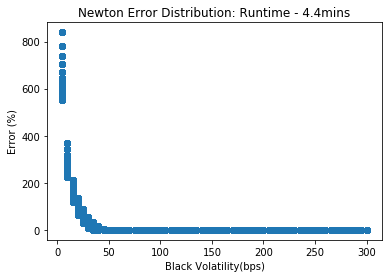

In [27]:
# 1) Newton Results
start_time = time.time()
price = Black_Vect(N, S0, data[:,1], data[:,2], K, data[:,0])
vol_approx = Newton_Vect(N, S0, data[:,1], data[:,2], K,price )
end_time = time.time()

# Find the speed of computation per iteration
len(data)
run_time = (end_time - start_time)/60

error_Newton = (vol_approx - data[:,0])*100/data[:,0]
plt.scatter(x = pd.DataFrame(data[:,0]*1e+4), y= pd.DataFrame(error_Newton))
plt.style.use('dark_background')
plt.title('Newton Error Distribution: Runtime - '+str(round(run_time, 2)) + 'mins')
plt.ylabel("Error (%)")
plt.xlabel("Black Volatility(bps)")

Text(0.5, 0, 'Black Volatility(bps)')

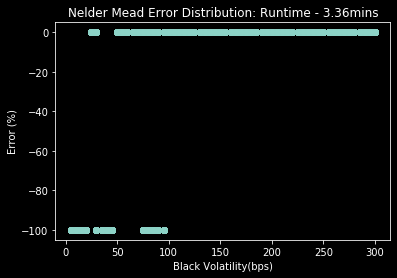

In [34]:
# 2) Nelder Mead Results
start_time = time.time()
price = Black_Vect(N, S0, data[:,1], data[:,2], K, data[:,0])
vol_approx_nm = NMead_Vect(N, S0, data[:,1], data[:,2], K,price )
end_time = time.time()

# Find the speed of computation per iteration
len(data)
run_time_NM = (end_time - start_time)/60

# Plot the error graph
error_Newton = (vol_approx_nm - data[:,0])*100/data[:,0]
plt.scatter(x = pd.DataFrame(data[:,0]*1e+4), y= pd.DataFrame(error_Newton))
plt.style.use('dark_background')
plt.title('Nelder Mead Error Distribution: Runtime - '+str(round(run_time_NM, 2)) + 'mins')
plt.ylabel("Error (%)")
plt.xlabel("Black Volatility(bps)")

Text(0.5, 0, 'Black Volatility(bps)')

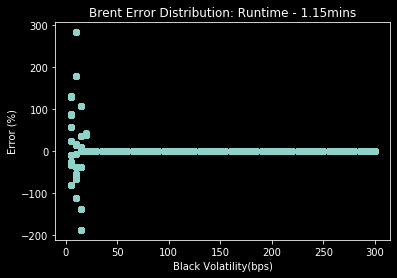

In [35]:
# 3) Brent Results
start_time = time.time()
price = Black_Vect(N, S0, data[:,1], data[:,2], K, data[:,0])
vol_approx_bt = Brent_Vect(N, S0, data[:,1], data[:,2], K,price )
end_time = time.time()

# Find the speed of computation per iteration
len(data)
run_time_BT = (end_time - start_time)/60

# Plot the error graph
error_Brent = (vol_approx_bt - data[:,0])*100/data[:,0]
plt.scatter(x = pd.DataFrame(data[:,0]*1e+4), y= pd.DataFrame(error_Brent))
plt.style.use('dark_background')
plt.title('Brent Error Distribution: Runtime - '+str(round(run_time_BT, 2)) + 'mins')
plt.ylabel("Error (%)")
plt.xlabel("Black Volatility(bps)")

Text(0.5, 0, 'Black Volatility(bps)')

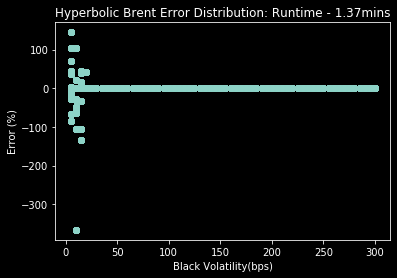

In [36]:
# 4) Brenth Results
start_time = time.time()
price = Black_Vect(N, S0, data[:,1], data[:,2], K, data[:,0])
vol_approx_bth = Brenth_Vect(N, S0, data[:,1], data[:,2], K,price )
end_time = time.time()

# Find the speed of computation per iteration
len(data)
run_time_BTH = (end_time - start_time)/60

# Plot the error graph
error_Brenth = (vol_approx_bth - data[:,0])*100/data[:,0]
plt.scatter(x = pd.DataFrame(data[:,0]*1e+4), y= pd.DataFrame(error_Brenth))
plt.style.use('dark_background')
plt.title('Hyperbolic Brent Error Distribution: Runtime - '+str(round(run_time_BTH, 2)) + 'mins')
plt.ylabel("Error (%)")
plt.xlabel("Black Volatility(bps)")

Text(0.5, 0, 'Black Volatility(bps)')

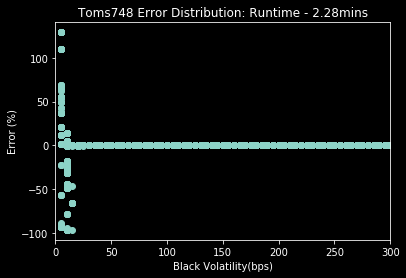

In [37]:
# 5) Toms748 Results
start_time = time.time()
price = Black_Vect(N, S0, data[:,1], data[:,2], K, data[:,0])
vol_approx_toms = Toms_Vect(N, S0, data[:,1], data[:,2], K,price )
end_time = time.time()

# Find the speed of computation per iteration
len(data)
run_time_toms = (end_time - start_time)/60

# Plot the error graph
error_toms = (vol_approx_toms - data[:,0])*100/data[:,0]
plt.scatter(x = pd.DataFrame(data[:,0]*1e+4), y= pd.DataFrame(error_toms))
plt.xlim(0, 300)
plt.style.use('dark_background')
plt.title('Toms748 Error Distribution: Runtime - '+str(round(run_time_toms, 2)) + 'mins')
plt.ylabel("Error (%)")
plt.xlabel("Black Volatility(bps)")

In [ ]:
        '''ANNEX
====================================='''
"TESTING WORKSPACE BEFORE CREATION OF THE FUNCTIONS"

N = 1e+5
S0 = 0.035
K = 0.04
sigma = 0.001
expiry = Date(4, 2, 2022) 
tenor = Date(4, 2, 2030)

# Price using Black Pricer
Price = payer_Black(N, S0, expiry, tenor, K, sigma)

func = lambda sigma: np.power(payer_Black(N, S0, expiry, tenor, K, sigma) - Price, 2.0)
vol  = optimize.fmin(func,x0 =0.0015, xtol = 1e-9, ftol = 1e-7)
vol